In [136]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)


In this example, we would like to estimate the location of the vehicle in the XY plane.

The vehicle has an onboard location sensor that reports X and Y coordinates of the system.

We assume constant acceleration dynamics.



In [122]:
# We generate the car's x.y coordinates that the Kalman filter is going to try to predict
def generate_true_pos():
    coords = []
    for i in range(400):
        coords.append((i,300))
    for i in range(300):
        coords.append(((i+400), np.sqrt(300**2 - i ** 2)))
    return coords
    
        

In [123]:
dt = 1
random_acceleration_std = 0.5
measurement_error_std = 3

full_coords = generate_true_pos()
true_coords = []
for i in range(len(full_coords)):
    if i % 5 == 0:
        true_coords.append(full_coords[i])

x_err = np.random.normal(0,3,len(true_coords))
y_err = np.random.normal(0,3,len(true_coords))

measured_coords = [(true_coords[i][0] + x_err[i], true_coords[i][1] + y_err[i]) for i in range(len(true_coords))]

In [124]:
#state transition matrix
F = np.identity(6)
F[0][1] = 1
F[1][2] = 1
F[3][4] = 1
F[4][5] = 1
F[0][2] = 0.5
F[3][5] = 0.5

In [125]:
#observation matrix
H = np.zeros((2,6))
H[0][0] = 1
H[1][3] = 1

In [126]:
# process noise matrix 
Q = np.identity(6)
Q[0][0] = 1/4
Q[3][3] = 1/4
for x,y in [(0,1),(0,2),(1,0),(2,0),(3,4),(3,5),(4,3),(5,3)]:
    Q[x][y] = 1/2
Q *=  (random_acceleration_std ** 2)

In [127]:
#measurement uncertainty 
R = np.array([[9,0],[0,9]])

In [128]:
# initilisation 
x_hat = np.zeros((1,6)).T 
P = np.identity(6) * 500 

In [129]:
#first prediction
P = F @ P @ F.T + Q

In [130]:
# iterations over the measurements

state_ests = []
preds = [x_hat] 
Ks = []

for i in range(len(measured_coords)):
    # step 1: measure
    z = np.array([[measured_coords[i][0]],[measured_coords[i][1]]])
    
    # step 2: update
    K = P @ H.T @ np.linalg.inv((H @ P @ H.T + R))
    Ks.append(K)
    x_est = preds[i] + K @ (z - H@preds[i])
    P_curr = (np.identity(6) - K @ H) @ P @ (np.identity(6) - K @ H).T + K @ R @ K.T
    state_ests.append(x_est)
    
    #step 3: predict
    x_pred = F @ x_est
    P = F @ P_curr @ F.T + Q
    preds.append(x_pred)
    
    

In [131]:
est_coords = [(est[0][0], est[3][0]) for est in state_ests]

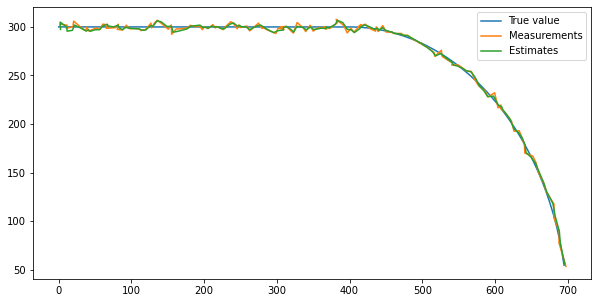

In [137]:
plt.plot([coord[0] for coord in true_coords],[coord[1] for coord in true_coords], label = 'True value')
plt.plot([coord[0] for coord in measured_coords], [coord[1] for coord in measured_coords], label= 'Measurements')
plt.plot([coord[0] for coord in est_coords], [coord[1] for coord in est_coords], label= 'Estimates')
plt.legend()

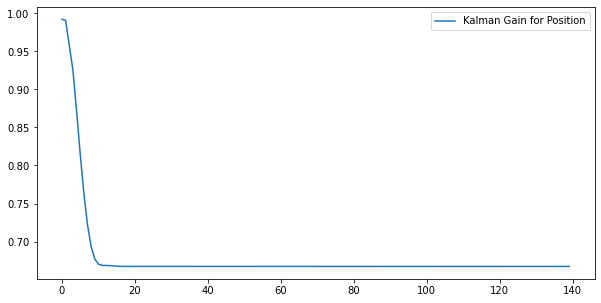

In [138]:
plt.plot([K[0][0] for K in Ks],label = 'Kalman Gain for Position')
plt.legend()